In [ ]:
# default_exp engine.point_process

In [ ]:
%load_ext autoreload
%autoreload 2

# Emitter distribution

> Definition of the class used to simulate random emitter positions and intensities

In [ ]:
#export
from decode_fish.imports import *
from torch import distributions as D, Tensor
from torch.distributions import Distribution
from decode_fish.funcs.utils import *

In [ ]:
#export
class PointProcessUniform(Distribution):
    """
    This class is part of the generative model and uses probability local_rate to generate locations `locations`  `x`, `y`, `z` offsets and `intensities` intensity of emitters. local_rate  should be `torch.tensor` scaled from 0.001 to 1), which is used by `_sample_bin` to generate `0` and `1` . `0` means that we don't have an emitter at a given pixel, and 1 means emitters is present. This map is used to generate offset in `x`, `y`, `z`, and intensities, which tells how bright is emitter or, in some cases, how many emitters are bound to given molecules.
    Args:
        local_rate (BS, C, H, W, D): Local rate
        min_int (int): minimum intensity of emitters
        bg(bool): if returns sampled backround

    """
    def __init__(self, local_rate: torch.tensor, int_mu=0., int_sig = 1., sim_iters: int = 5):

        self.local_rate = local_rate
        self.device = self._get_device(self.local_rate)
        self.sim_iters = sim_iters
        self.int_mu = int_mu
        self.int_sig = int_sig
        
    def sample(self):

        res_ = [self._sample(self.local_rate/self.sim_iters) for i in range(self.sim_iters)]
        locations = torch.cat([i[0] for i in res_], dim=0)
        x_offset = torch.cat([i[1] for i in res_], dim=0)
        y_offset = torch.cat([i[2] for i in res_], dim=0)
        z_offset = torch.cat([i[3] for i in res_], dim=0)
        intensities = torch.cat([i[4] for i in res_], dim=0)

        return tuple(locations.T), x_offset, y_offset, z_offset, intensities, res_[0][5]

    def _sample(self, local_rate):

        local_rate = torch.clamp_max(local_rate, 1.)
        locations = D.Bernoulli(local_rate).sample()
        n_emitter = int(locations.sum().item())
        zero_point_five = torch.tensor(0.5, device=self.device)
        x_offset = D.Uniform(low=0 - zero_point_five, high=0 + zero_point_five).sample(sample_shape=[n_emitter])
        y_offset = D.Uniform(low=0 - zero_point_five, high=0 + zero_point_five).sample(sample_shape=[n_emitter])
        z_offset = D.Uniform(low=0 - zero_point_five, high=0 + zero_point_five).sample(sample_shape=[n_emitter])
        intensities = D.Normal(self.int_mu, self.int_sig).sample(sample_shape=[n_emitter]).to(self.device)
        
        output_shape = tuple(locations.shape)
        locations = locations.nonzero(as_tuple=False)
        return locations, x_offset, y_offset, z_offset, intensities, output_shape


    def log_prob(self, locations, x_offset=None, y_offset=None, z_offset=None, intensities=None, output_shape=None):
        locations = list_to_locations(locations, output_shape)
        log_prob = D.Bernoulli(self.local_rate).log_prob(locations)
        return log_prob

    @staticmethod
    def _get_device(x):
        return getattr(x, 'device')
    

def list_to_locations(locations, output_shape):
    tmp =torch.zeros(output_shape, device=locations[0].device)
    coord = torch.stack(locations).T
    #incase you have multiple emitter present
    for i in coord: tmp[tuple(i)] += 1
    return tmp

In [ ]:
point_process = PointProcessUniform(local_rate = torch.ones([1,1,48,48,48])*.01, int_mu=5, sim_iters=10)
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = point_process.sample()

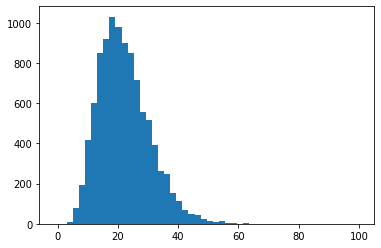

In [ ]:
_ = plt.hist(cpu(torch.distributions.gamma.Gamma(2/0.3,0.3).sample([10000])), bins=np.linspace(-1,100,51))

(array([  4.,  18.,  58., 163., 244., 256., 193., 112.,  46.,  13.]),
 array([1.8490317, 2.4349258, 3.02082  , 3.606714 , 4.192608 , 4.778502 ,
        5.364396 , 5.95029  , 6.5361843, 7.1220784, 7.7079725],
       dtype=float32),
 <BarContainer object of 10 artists>)

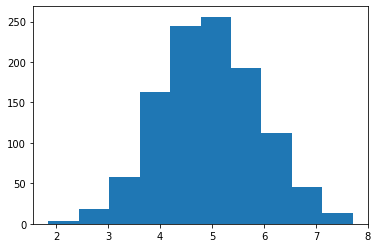

In [ ]:
plt.hist(ints_3d.numpy())

In [ ]:
vol = torch.zeros(output_shape)
for i in range(len(locs_3d[0])):
    vol[locs_3d[0][i],locs_3d[1][i],locs_3d[2][i],locs_3d[3][i],locs_3d[4][i]] += 1

In [ ]:
from decode_fish.funcs.plotting import *

In [ ]:
vol.max(), vol.sum()

(tensor(3.), tensor(5479.))

array([<AxesSubplot:xlabel='x', ylabel='y'>,
       <AxesSubplot:xlabel='x', ylabel='z'>,
       <AxesSubplot:xlabel='y', ylabel='z'>], dtype=object)

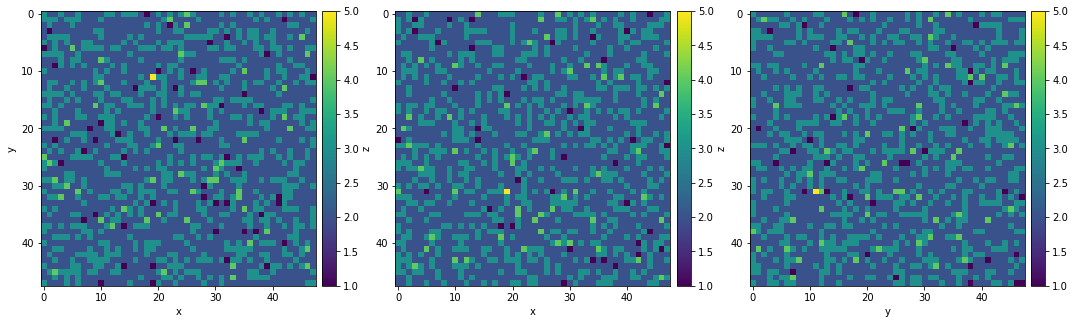

In [ ]:
plot_3d_projections(vol[0,0], 'max')

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted index.ipynb.
